# BBPSSW Protocol 

In [1]:
#imports
from qutip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, cnot
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qutip_qip.device import LinearSpinChain
from qutip_qip.noise import DecoherenceNoise
from qutip.qip.operations.gates import (rx, ry, rz, sqrtnot, snot, phasegate,
                                        x_gate, y_gate, z_gate, cy_gate,
                                        cz_gate, s_gate, t_gate, cs_gate,
                                        qasmu_gate, ct_gate, cphase, cnot,
                                        csign, berkeley, swapalpha, swap,
                                        iswap, sqrtswap, sqrtiswap, fredkin,
                                        toffoli, controlled_gate, globalphase,
                                        expand_operator, gate_sequence_product)
from qutip_qip.operations import (
    Gate, controlled_gate, hadamard_transform)

In [2]:
#initialisations
phi_plus = bell_state("00")
phi_minus = bell_state("01")
psi_plus = bell_state("10")
psi_minus = bell_state("11")

fidelity_val = 0.60

In [3]:
def F_to_theta(F):
    """Returns the angle theta corresponding to an input fidelity F.
    
    Keyword arguments:
    F -- fidelity between 0 and 1
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    
    return theta

In [4]:
control_qubits = [0,1]
target_qubits = [2,3]

In [5]:
def bilateral_rotation(circuit, qubits, rot_idx):
    """Adds a bilateral rotation to a quantum circuit.
    
    Keyword arguments:
    circuit --  quantum circuit to which the rotations are added
    qubits -- alist of qubits, each of which is rotated
    rot_idx -- integer that numbers the rotations from the set of all rotations, ranges from 0 to 11
    """
    for qubit_number in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 2:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 3:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 4:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 5:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 6:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 7:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 8:
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 9:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            
        elif rot_idx == 10:
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RZ", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        elif rot_idx == 11:
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RY", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})
            circuit.add_gate("RX", targets=[qubit_number], arg_value=pi / 2, style={"showarg": True})

            
        else:
            raise Exception('Input argument rot_idx has to be an integer between 0 and 11.')

In [19]:
# #create circuit that generates source
# qc = QubitCircuit(4)
# qc.add_gate("X", targets=[1])
# #qasmu gate
# qc.add_gate("RZ", targets=[0], arg_value=0, style={"showarg": True})
# qc.add_gate("RY", targets=[0], arg_value=(F_to_theta(fidelity_val)), style={"showarg": True})
# qc.add_gate("RZ", targets=[0], arg_value=0, style={"showarg": True})

# qc.add_gate("CNOT", controls=[0], targets=[1])
# qc.add_gate("X", targets=[3])

# #qasmu gate
# qc.add_gate("RZ", targets=[2], arg_value=0, style={"showarg": True})
# qc.add_gate("RY", targets=[2], arg_value=(F_to_theta(fidelity_val)), style={"showarg": True})
# qc.add_gate("RZ", targets=[2], arg_value=0, style={"showarg": True})

# qc.add_gate("CNOT", controls=[2], targets=[3])

# #generate werner state from source using random bilateral rotations
# rand_int = np.random.randint(12)
# bilateral_rotation(qc, control_qubits, rand_int)
# bilateral_rotation(qc, target_qubits, rand_int)
# qc.draw("matplotlib", dpi=150)

#verify that we have a valid werner state

# #bbpssw protocol steps  
# qc.add_gate("Y", targets=[0])
# qc.add_gate("Y", targets=[2])
# qc.add_gate("CNOT", controls=[0], targets=[2])
# qc.add_gate("CNOT", controls=[1], targets=[3])
# # qc.add_measurement("M0", targets=[2], classical_store=[0])
# # qc.add_measurement("M1", targets=[3], classical_store=[1])
# qc.draw("matplotlib", dpi=150)


In [7]:
#CUSTOM CONTROLLED HADAMARD GATE

def controlled_hadamard():
    # Controlled Hadamard
    return controlled_gate(
        hadamard_transform(1), controls=0, targets=1, control_value=1)


In [ ]:
werner_circuit = QubitCircuit(N=5)
werner_circuit.user_gates = {"cH": controlled_hadamard}
werner_circuit.add_gate("RY", targets=[0], arg_value= pi/2, style={"showarg": True})
werner_circuit.add_gate("CNOT", controls=[0], targets=[2])
werner_circuit.add_gate("H", targets=[0])
werner_circuit.add_gate("CX", controls=[2], targets=[1])
werner_circuit.add_gate("X", targets=[2])
werner_circuit.add_gate("cH", targets=[1,2])
werner_circuit.add_gate("X", targets=[2])
werner_circuit.add_gate("TOFFOLI", controls=[2,0], targets=[1])
werner_circuit.add_gate("X", targets=[2])
werner_circuit.add_gate("TOFFOLI", controls=[0,2], targets=[3])
werner_circuit.add_gate("TOFFOLI", controls=[1,2], targets=[4])

werner_circuit.draw("matplotlib", dpi=200)

In [ ]:
from qutip import tensor, basis
zero_state = tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0))
result = werner_circuit.run(state=zero_state)

# print(result)
print(tensor(result.ptrace(0), result.ptrace(1)))
print(result.ptrace([0,1]))

In [ ]:
werner_circuit_2 = QubitCircuit(N=2, num_cbits=3)
werner_circuit_2.add_gate("RY", targets=[0], arg_value= pi/2, style={"showarg": True})
werner_circuit_2.add_measurement("M0", targets=0, classical_store=0)
werner_circuit_2.add_gate("X", targets=1, classical_controls=[2], control_value=1)
werner_circuit_2.add_gate("H", targets = 0)
werner_circuit_2.add_gate("H", targets=1, classical_controls=[0], control_value=0)
werner_circuit_2.add_gate("CX", targets=1, controls=0)
werner_circuit_2.add_measurement("M1", targets=[0,1], classical_store=1)
werner_circuit_2.draw("matplotlib", dpi=200)

In [ ]:
def check_werner_r1(rho, tol=1e-6):
    """
    Check whether a 4x4 matrix rho corresponds to the Werner-type state:
    rho_W = r1 * |1><1| + (1-r1)/3 * (I4 - |1><1|)
    where |1> = (|01> - |10>)/sqrt(2).
    In the computational basis {|00>, |01>, |10>, |11>}, the matrix form is:
    rho_W = [[(1-r1)/3, 0, 0, 0],
    [0, (2*r1+1)/6, (1-4*r1)/6, 0],
    [0, (1-4*r1)/6, (2*r1+1)/6, 0],
    [0, 0, 0, (1-r1)/3]]
    Parameters
    ----------
    rho : 2D numpy array (shape (4,4))
    The density matrix to test.
    tol : float
    Numerical tolerance for consistency checks.
    Returns
    -------
    (is_werner, r1_value)
    is_werner : bool
    True if all derived r1 values match within 'tol'.
    r1_value : float or None
    The average r1 if consistent, else None.
    """

    # Corner diagonals (should be (1-r1)/3):

    corner_val = rho[0, 0] # same as rho[3,3] ideally

    # Center diagonals (should be (2*r1 + 1)/6):

    center_diag_val = rho[1, 1] # same as rho[2,2] ideally

    # Off-diagonals in the center block (should be (1 - 4*r1)/6):

    center_offdiag_val = rho[1, 2] # same as rho[2,1] ideally

    # Solve for r1 from each expression:

    # 1) corner_val = (1 - r1)/3 => r1 = 1 - 3 * corner_val

    r1_corner = 1.0 - 3.0 * corner_val

    # 2) center_diag_val = (2*r1 + 1)/6 => 2*r1 + 1 = 6*center_diag_val => r1 = 3*center_diag_val - 0.5

    r1_center_diag = 3.0 * center_diag_val - 0.5

    # 3) center_offdiag_val = (1 - 4*r1)/6 => 1 - 4*r1 = 6*center_offdiag_val => r1 = (1 - 6*center_offdiag_val)/4

    r1_center_offdiag = (1.0 - 6.0 * center_offdiag_val) / 4.0

    # Put them all in a list

    r1_candidates = [r1_corner, r1_center_diag, r1_center_offdiag]

    # Check if they are all close within 'tol'
    if (np.allclose(r1_corner, r1_center_diag, atol=tol) and np.allclose(r1_corner, r1_center_offdiag, atol=tol)):

        # If consistent, return average

        r1_mean = np.mean(r1_candidates)
        return True, r1_mean
    else:
    # Not consistent -> not a Werner state of this specific form
        return False, None

print(check_werner_r1(result.ptrace([0,1])))

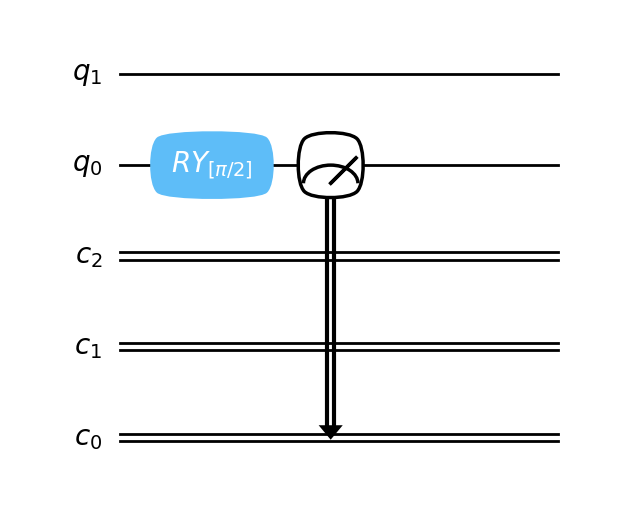

In [41]:
qc = QubitCircuit(2, num_cbits=3)
qc.add_gate("RY", targets=[0], arg_value=pi/2, style={"showarg": True})
qc.add_measurement("M0", targets=0, classical_store=0)

qc.draw("matplotlib", dpi=200)

